<a href="https://colab.research.google.com/github/fahimku2020/fahimku2020/blob/main/Bert_clustering_with_b8gram_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers
!pip install wikipedia
!pip install nltk
!pip install torch
!pip install sklearn
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=89e6439c96c79c8d1da9fbd0090e84784eebb60443ac6d78a3fbb01b24725e4f
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See abov

Enter Wikipedia topic: Amitabh Bachan 
Enter epsilon for clustering (default 0.5): 0.6
Enter minimum samples per cluster (default 2): 5

--- Clustering Results ---

Cluster 0 (Size: 85):
Most Frequent Words:
  - film: 45
  - bachchan: 31
  - actor: 28
  - best: 27
  - filmfare: 25
  - award: 25
  - films: 16
  - box: 13
  - office: 13
  - year: 13

Cluster 1 (Size: 18):
Most Frequent Words:
  - bachchan: 21
  - amitabh: 10
  - family: 6
  - bachchans: 5
  - name: 5
  - father: 5
  - hindi: 4
  - born: 3
  - poet: 3
  - harivansh: 3

Cluster 2 (Size: 5):
Most Frequent Words:
  - college: 7
  - kirori: 3
  - mal: 3
  - delhi: 3
  - sherwood: 2
  - nainital: 2
  - university: 2
  - secondary: 2
  - school: 2
  - government: 2

Cluster 3 (Size: 4):
Most Frequent Words:
  - zanjeer: 3
  - angry: 3
  - young: 3
  - man: 3
  - salim: 2
  - khan: 2
  - lead: 2
  - role: 2
  - romantic: 2
  - hero: 2

Cluster 4 (Size: 7):
Most Frequent Words:
  - season: 6
  - bachchan: 5
  - hosted: 5
  - kbc:

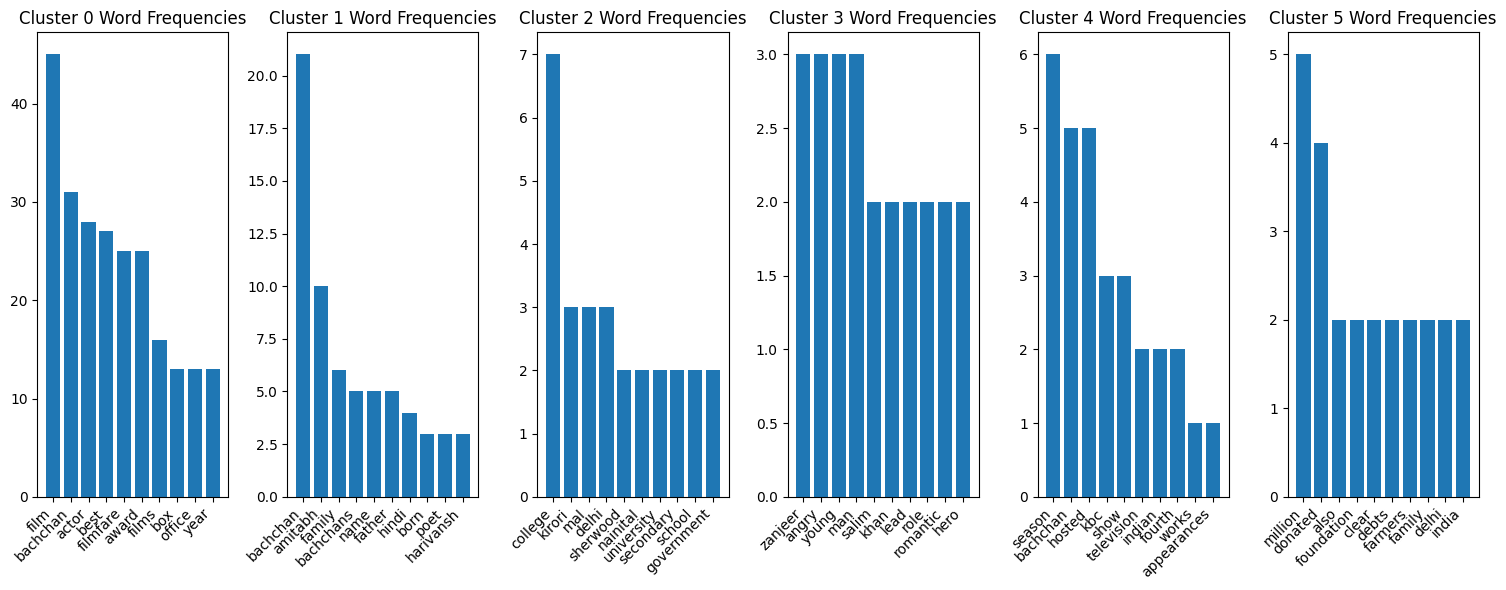

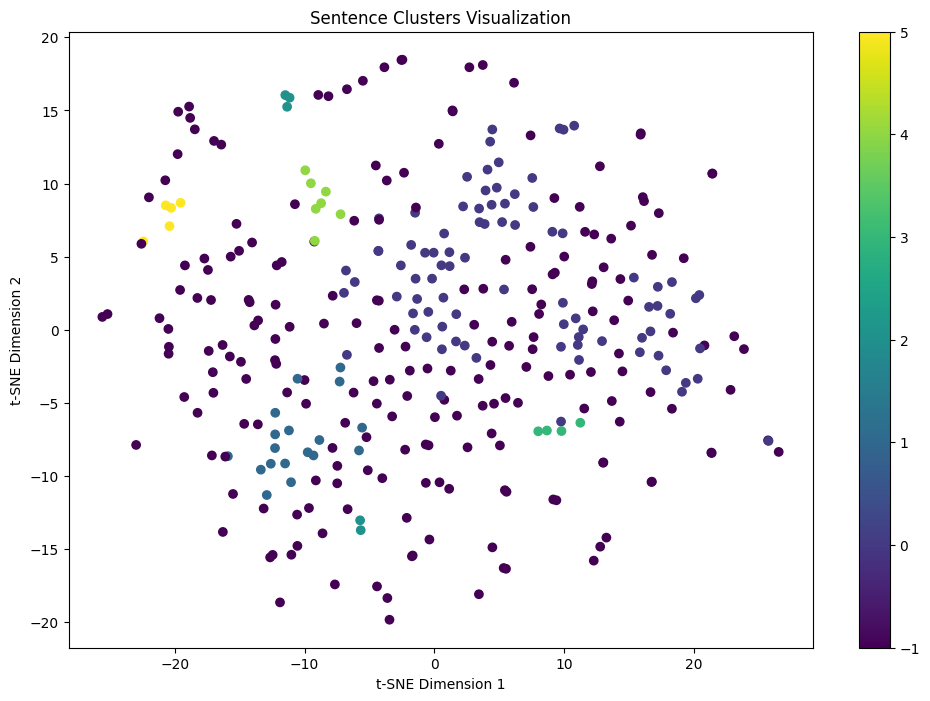

In [ ]:
import re
import time
import numpy as np
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

class BERTSentenceClustering:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        # Download NLTK resources
        nltk.download('punkt_tab', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize BERT model
        self.model = SentenceTransformer(model_name)

        # Comprehensive stopwords
        self.stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'furthermore', 'however', 'additionally', 'nonetheless',
            'moreover', 'consequently', 'subsequently', 'alternatively'
        }
        self.stop_words.update(custom_stopwords)

    def fetch_wikipedia_content(self, topic):
        """Fetch Wikipedia article content"""
        try:
            page = wikipedia.page(topic)
            return page.content
        except Exception as e:
            print(f"Error fetching content: {e}")
            return None

    def preprocess_sentences(self, text):
        """Advanced text preprocessing for sentences"""
        # Tokenize sentences
        sentences = sent_tokenize(text)

        processed_sentences = []
        for sentence in sentences:
            # Lowercase and remove special characters
            sentence = re.sub(r'[^a-z\s]', '', sentence.lower())

            # Tokenize words
            words = word_tokenize(sentence)

            # Remove stopwords and short words
            filtered_words = [
                word for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            # Reconstruct sentence
            if filtered_words:
                processed_sentences.append(' '.join(filtered_words))

        return processed_sentences

    def compute_sentence_embeddings(self, sentences):
        """Compute BERT embeddings with optimization"""
        # Use GPU if available
        if torch.cuda.is_available():
            self.model.to('cuda')

        # Batch processing
        batch_size = 32
        embeddings = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            batch_embeddings = self.model.encode(batch, show_progress_bar=False)
            embeddings.append(batch_embeddings)

        embeddings = np.vstack(embeddings)

        # Normalize embeddings
        return StandardScaler().fit_transform(embeddings)

    def cluster_sentences(self, embeddings, eps=0.5, min_samples=2):
        """Cluster sentences using DBSCAN"""
        return DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='cosine'
        ).fit(embeddings).labels_

    def compute_similarity_matrix(self, embeddings):
        """Compute pairwise similarity scores"""
        return np.round(1 - cosine_similarity(embeddings), decimals=2)

    def find_most_frequent_words(self, sentences):
        """Find most frequent words in each cluster"""
        # Tokenize and flatten words
        all_words = [word for sentence in sentences for word in sentence.split()]
        return Counter(all_words).most_common(10)

    def plot_cluster_word_frequencies(self, sentences, labels):
        """Plot word frequency distribution for each cluster"""
        plt.figure(figsize=(15, 6))
        unique_clusters = set(labels)

        for cluster in unique_clusters:
            if cluster == -1:
                continue

            # Get sentences in this cluster
            cluster_sentences = [
                sentences[i] for i in range(len(sentences)) if labels[i] == cluster
            ]

            # Find most frequent words
            word_freq = Counter([
                word for sentence in cluster_sentences
                for word in sentence.split()
            ])

            top_words = word_freq.most_common(10)

            # Plot
            plt.subplot(1, len(unique_clusters)-1, list(unique_clusters).index(cluster)+1)
            plt.bar(
                [word for word, count in top_words],
                [count for word, count in top_words]
            )
            plt.title(f'Cluster {cluster} Word Frequencies')
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    def plot_clusters(self, embeddings, labels):
        """Visualize clusters using t-SNE"""
        from sklearn.manifold import TSNE

        # Reduce dimensionality
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Plot
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            embeddings_2d[:, 0],
            embeddings_2d[:, 1],
            c=labels,
            cmap='viridis'
        )
        plt.colorbar(scatter)
        plt.title('Sentence Clusters Visualization')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.show()

    def process_document(self, topic, eps=0.5, min_samples=2):
        """Main processing method"""
        # Fetch and preprocess content
        content = self.fetch_wikipedia_content(topic)
        if not content:
            return

        sentences = self.preprocess_sentences(content)

        # Compute embeddings and cluster
        embeddings = self.compute_sentence_embeddings(sentences)
        labels = self.cluster_sentences(embeddings, eps, min_samples)

        # Compute similarity matrix
        similarity_matrix = self.compute_similarity_matrix(embeddings)

        # Print clustering results
        print("\n--- Clustering Results ---")
        unique_clusters = set(labels)
        for cluster in unique_clusters:
            if cluster != -1:
                cluster_sentences = [
                    sentences[i] for i in range(len(sentences)) if labels[i] == cluster
                ]
                print(f"\nCluster {cluster} (Size: {len(cluster_sentences)}):")

                # Most frequent words
                most_common_words = self.find_most_frequent_words(cluster_sentences)
                print("Most Frequent Words:")
                for word, count in most_common_words:
                    print(f"  - {word}: {count}")

        # Visualizations
        self.plot_cluster_word_frequencies(sentences, labels)
        self.plot_clusters(embeddings, labels)

        return sentences, labels, similarity_matrix

def main():
    # Create clustering instance
    clusterer = BERTSentenceClustering()

    # User inputs
    topic = input("Enter Wikipedia topic: ")
    eps = float(input("Enter epsilon for clustering (default 0.5): ") or 0.5)
    min_samples = int(input("Enter minimum samples per cluster (default 2): ") or 2)

    # Process document
    clusterer.process_document(topic, eps, min_samples)

if __name__ == "__main__":
    main()

Enter Wikipedia topic: Amitabh Bachan 
Enter epsilon for clustering (default 0.5): 0.65
Enter minimum samples per cluster (default 2): 5

--- Clustering Results ---

Cluster 0 (Size: 192):
  - amitabh bachchan pronounced mtb btn born amitabh srivastava october indian actor works hindi cinema
  - often considered one greatest accomplished commercially successful actors history indian cinema
  - cinematic career spanning five decades played pivotal roles films

Cluster 1 (Size: 7):
  - educated sherwood college nainital kirori mal college university delhi
  - bachchans secondary education boys high school college allahabad sherwood college nainital
  - attended kirori mal college university delhi delhi

Cluster 2 (Size: 11):
  - required emergency splenectomy remained critically ill hospital many months times close death
  - long queues wellwishing fans outside hospital recuperating public response included prayers places worship offers sacrifice limbs save
  - illness weakened mentally 

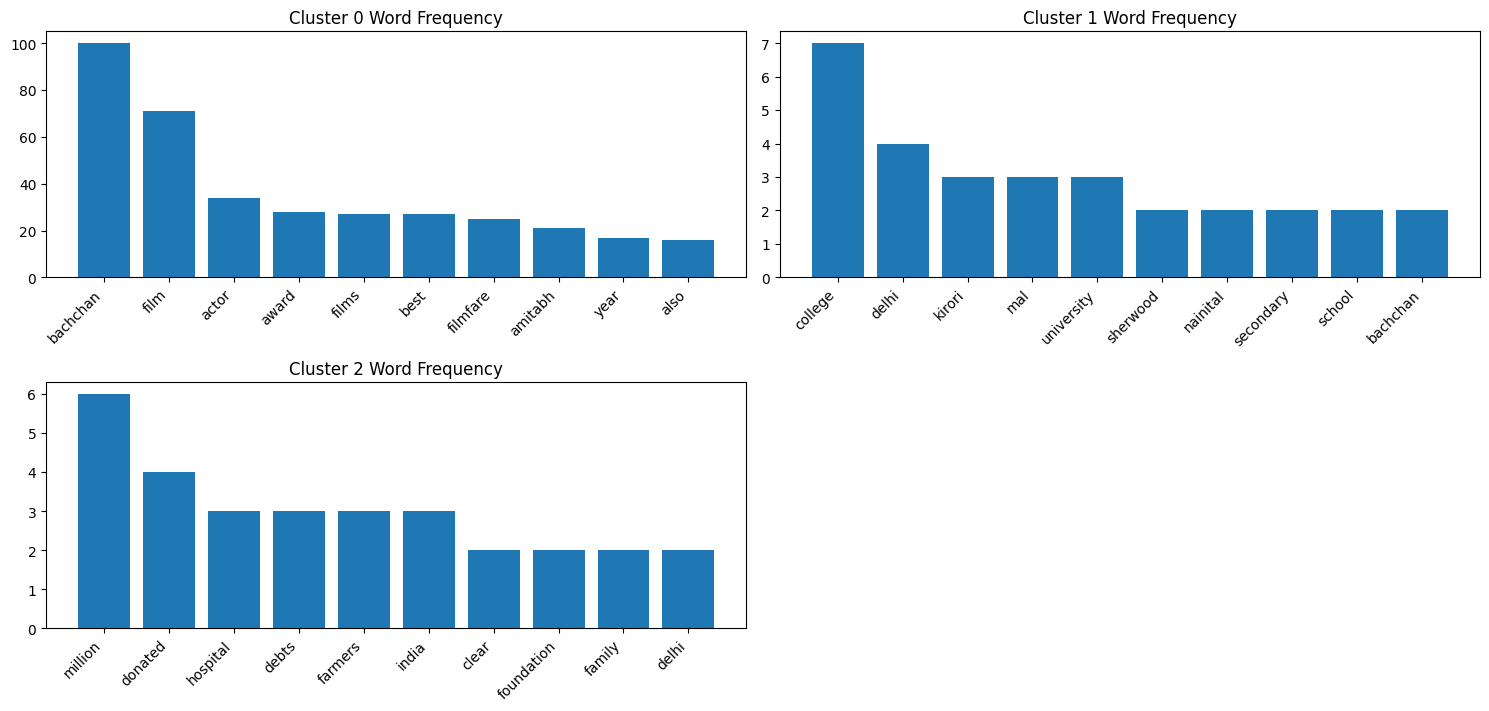

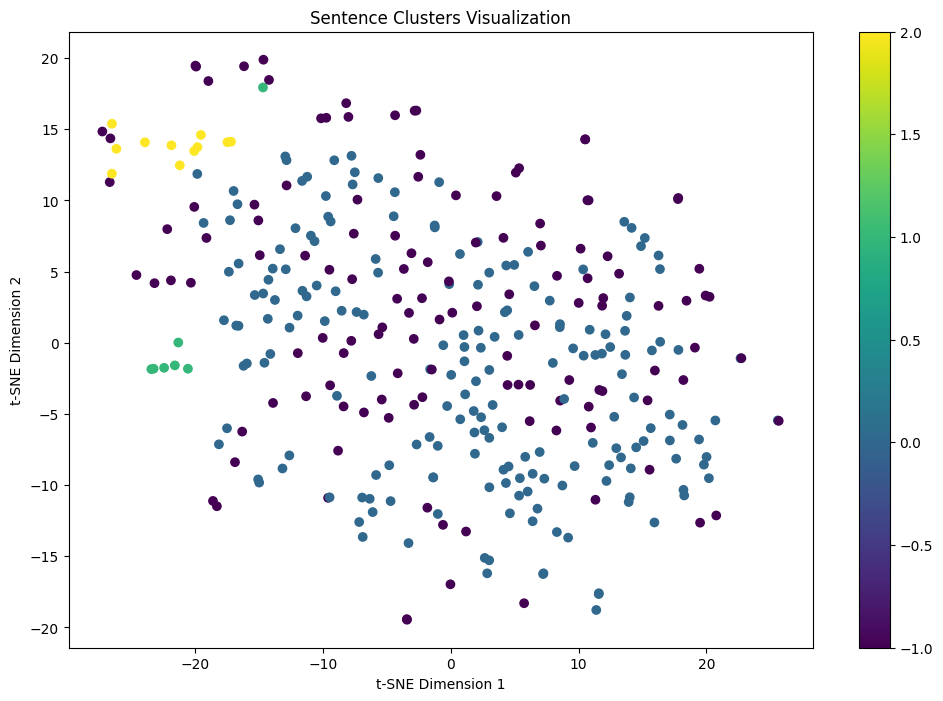

In [ ]:
import re
import numpy as np
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

class BERTSentenceClustering:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        # Download NLTK resources
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize BERT model
        self.model = SentenceTransformer(model_name)

        # Comprehensive stopwords
        self.stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'furthermore', 'however', 'additionally', 'nonetheless',
            'moreover', 'consequently', 'subsequently', 'alternatively',
            'specifically', 'particularly', 'notably', 'essentially'
        }
        self.stop_words.update(custom_stopwords)

    def fetch_wikipedia_content(self, topic):
        """Fetch Wikipedia article content"""
        try:
            page = wikipedia.page(topic)
            return page.content
        except Exception as e:
            print(f"Error fetching content: {e}")
            return None

    def preprocess_sentences(self, text):
        """Advanced text preprocessing"""
        # Tokenize sentences
        sentences = sent_tokenize(text)

        processed_sentences = []
        for sentence in sentences:
            # Lowercase
            sentence = sentence.lower()

            # Remove special characters and digits
            sentence = re.sub(r'[^a-z\s]', '', sentence)

            # Tokenize words
            words = word_tokenize(sentence)

            # Remove stopwords and short words
            filtered_words = [
                word for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            # Reconstruct sentence
            if filtered_words:
                processed_sentences.append(' '.join(filtered_words))

        return processed_sentences

    def compute_sentence_embeddings(self, sentences):
        """Compute BERT embeddings with optimization"""
        # GPU acceleration
        if torch.cuda.is_available():
            self.model.to('cuda')

        # Batch processing
        batch_size = 32
        embeddings = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            batch_embeddings = self.model.encode(batch, show_progress_bar=False)
            embeddings.append(batch_embeddings)

        embeddings = np.vstack(embeddings)

        # Normalize embeddings
        return StandardScaler().fit_transform(embeddings)

    def cluster_sentences(self, embeddings, sentences, eps=0.5, min_samples=5):
        """Cluster sentences using DBSCAN"""
        clustering = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='cosine'
        ).fit(embeddings)

        return clustering.labels_

    def compute_similarity_matrix(self, embeddings):
        """Compute pairwise similarity scores"""
        from sklearn.metrics.pairwise import cosine_similarity
        return 1 - np.round(cosine_similarity(embeddings), decimals=2)

    def find_most_frequent_words(self, sentences_by_cluster):
        """Find most frequent words in each cluster"""
        frequent_words = {}
        for cluster, sentences in sentences_by_cluster.items():
            # Combine all sentences in the cluster
            cluster_text = ' '.join(sentences)

            # Tokenize and remove stopwords
            words = [
                word for word in word_tokenize(cluster_text.lower())
                if word not in self.stop_words and len(word) > 2
            ]

            # Find most common words
            word_freq = Counter(words)
            frequent_words[cluster] = word_freq.most_common(3)

        return frequent_words

    def plot_word_frequency(self, sentences_by_cluster):
        """Plot word frequency distribution for each cluster"""
        plt.figure(figsize=(15, 10))

        for i, (cluster, sentences) in enumerate(sentences_by_cluster.items(), 1):
            # Combine all sentences in the cluster
            cluster_text = ' '.join(sentences)

            # Tokenize and remove stopwords
            words = [
                word for word in word_tokenize(cluster_text.lower())
                if word not in self.stop_words and len(word) > 2
            ]

            # Count word frequencies
            word_freq = Counter(words)

            # Plot for top 10 words
            top_words = word_freq.most_common(10)

            plt.subplot(3, 2, i)
            plt.bar([word for word, count in top_words], [count for word, count in top_words])
            plt.title(f'Cluster {cluster} Word Frequency')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

        plt.show()

    def plot_clusters(self, embeddings, labels):
        """Visualize clusters using t-SNE"""
        from sklearn.manifold import TSNE

        # Reduce dimensionality
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Plot
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            embeddings_2d[:, 0],
            embeddings_2d[:, 1],
            c=labels,
            cmap='viridis'
        )
        plt.colorbar(scatter)
        plt.title('Sentence Clusters Visualization')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.show()

    def process_document(self, topic, eps=0.5, min_samples=2):
        """Main processing method"""
        # Fetch content
        content = self.fetch_wikipedia_content(topic)
        if not content:
            return

        # Preprocess sentences
        sentences = self.preprocess_sentences(content)

        # Compute embeddings
        embeddings = self.compute_sentence_embeddings(sentences)

        # Cluster sentences
        labels = self.cluster_sentences(
            embeddings,
            sentences,
            eps=eps,
            min_samples=min_samples
        )

        # Organize sentences by cluster
        sentences_by_cluster = {}
        for label in set(labels):
            if label != -1:
                cluster_sentences = [
                    sentences[i] for i in range(len(sentences)) if labels[i] == label
                ]
                sentences_by_cluster[label] = cluster_sentences

        # Compute similarity matrix
        similarity_matrix = self.compute_similarity_matrix(embeddings)

        # Print cluster details
        print("\n--- Clustering Results ---")
        for cluster, cluster_sentences in sentences_by_cluster.items():
            print(f"\nCluster {cluster} (Size: {len(cluster_sentences)}):")
            # Print first 3 sentences
            for sentence in cluster_sentences[:3]:
                print(f"  - {sentence}")

        # Find most frequent words
        frequent_words = self.find_most_frequent_words(sentences_by_cluster)
        print("\n--- Most Frequent Words per Cluster ---")
        for cluster, words in frequent_words.items():
            print(f"Cluster {cluster}: {words}")

        # Visualizations
        self.plot_word_frequency(sentences_by_cluster)
        self.plot_clusters(embeddings, labels)

        return sentences, labels, similarity_matrix

def main():
    # Create clustering instance
    clusterer = BERTSentenceClustering()

    # Get user inputs
    topic = input("Enter Wikipedia topic: ")
    eps = float(input("Enter epsilon for clustering (default 0.5): ") or 0.5)
    min_samples = int(input("Enter minimum samples per cluster (default 2): ") or 2)

    # Process document
    clusterer.process_document(topic, eps, min_samples)

if __name__ == "__main__":
    main()

Enter Wikipedia topic: Amitabh Bachan 
Enter epsilon for clustering (default 0.5): 0.6
Enter minimum samples per cluster (default 2): 5

--- Clustering Results ---

Cluster 0 (Size: 85):
Top Bigrams:
  - best actor (Frequency: 21)
  - award best (Frequency: 14)
  - box office (Frequency: 13)
  - national film (Frequency: 7)
  - filmfare award (Frequency: 7)
Sample Sentences:
  * often considered one greatest accomplished commercially successful actors history indian cinema
  * cinematic career spanning five decades played pivotal roles films
  * bachchan often hailed shahenshah bollywood sadi mahanayak translated greatest actor century hindi star millennium simply big
  * recipient several accolades including six national film awards sixteen filmfare awards
  * first gained popularity earlys films anand zanjeer roti kapada aur makaan achieved greater stardom later years dubbed indias angry young man several onscreen roles hindi films
  * consistently starred topgrossing indian films mi

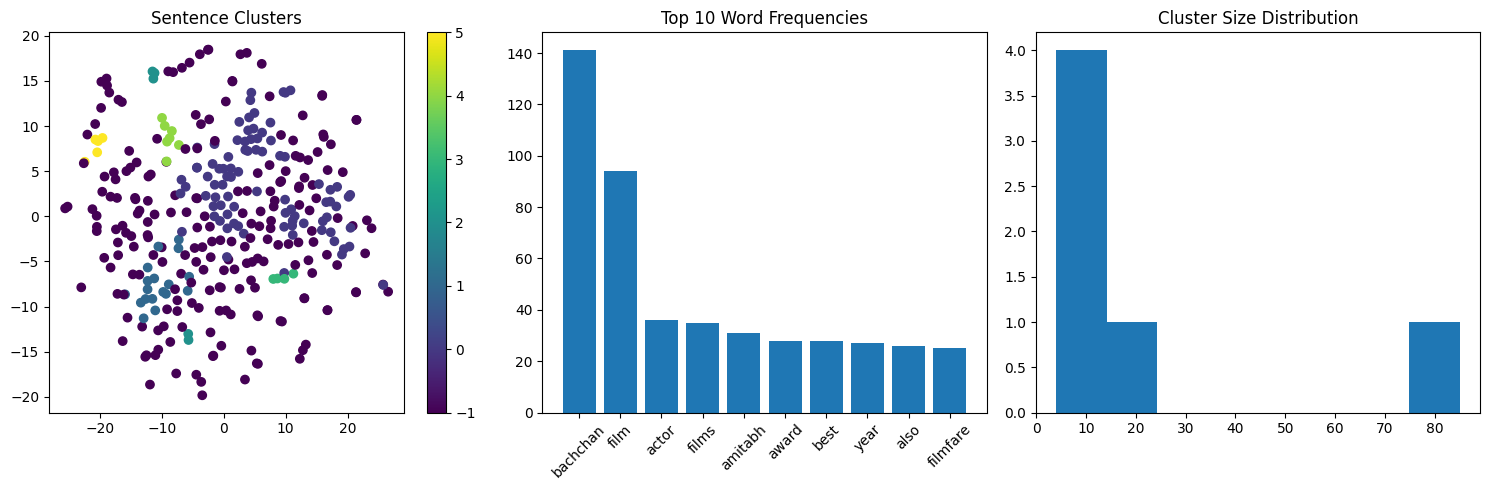

In [13]:
import re
import numpy as np
import wikipedia
import nltk
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import ngrams
from collections import Counter

from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

class BERTSentenceClustering:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        # Download NLTK resources
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)

        # Initialize BERT model
        self.model = SentenceTransformer(model_name)

        # Comprehensive stopwords
        self.stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'furthermore', 'however', 'additionally', 'nonetheless',
            'moreover', 'consequently', 'subsequently', 'alternatively'
        }
        self.stop_words.update(custom_stopwords)

    def fetch_wikipedia_content(self, topic):
        """Fetch Wikipedia article content"""
        try:
            page = wikipedia.page(topic)
            return page.content
        except Exception as e:
            print(f"Error fetching Wikipedia content: {e}")
            return None

    def preprocess_sentences(self, text):
        """Advanced text preprocessing for sentences"""
        # Tokenize sentences
        sentences = sent_tokenize(text)

        # Preprocessing
        processed_sentences = []
        for sentence in sentences:
            # Lowercase
            sentence = sentence.lower()

            # Remove special characters and digits
            sentence = re.sub(r'[^a-z\s]', '', sentence)

            # Tokenize words
            words = word_tokenize(sentence)

            # Remove stopwords and short words
            filtered_words = [
                word for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            # Reconstruct sentence
            if filtered_words:
                processed_sentences.append(' '.join(filtered_words))

        return processed_sentences

    def compute_sentence_embeddings(self, sentences):
        """Compute BERT embeddings with GPU optimization"""
        if torch.cuda.is_available():
            self.model.to('cuda')

        # Batch processing
        batch_size = 32
        embeddings = []

        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            batch_embeddings = self.model.encode(batch, show_progress_bar=False)
            embeddings.append(batch_embeddings)

        embeddings = np.vstack(embeddings)
        return StandardScaler().fit_transform(embeddings)

    def extract_bigrams(self, sentences):
        """Extract most common bigrams for each sentence"""
        bigram_clusters = {}

        for sentence in sentences:
            # Tokenize sentence
            words = word_tokenize(sentence.lower())

            # Remove stopwords
            filtered_words = [
                word for word in words
                if word not in self.stop_words and len(word) > 2
            ]

            # Generate bigrams
            sentence_bigrams = list(ngrams(filtered_words, 2))

            # Convert bigrams to strings
            bigram_strs = [' '.join(bg) for bg in sentence_bigrams]

            # Add to counter
            for bigram in bigram_strs:
                if bigram not in bigram_clusters:
                    bigram_clusters[bigram] = 1
                else:
                    bigram_clusters[bigram] += 1

        return sorted(bigram_clusters.items(), key=lambda x: x[1], reverse=True)

    def cluster_sentences(self, embeddings, eps=0.5, min_samples=5):
        """Cluster sentences using DBSCAN"""
        return DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='cosine'
        ).fit(embeddings).labels_

    def plot_visualizations(self, embeddings, labels, sentences):
        """Create multiple visualizations"""
        # t-SNE for cluster visualization
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Cluster Scatter Plot
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        scatter = plt.scatter(
            embeddings_2d[:, 0],
            embeddings_2d[:, 1],
            c=labels,
            cmap='viridis'
        )
        plt.colorbar(scatter)
        plt.title('Sentence Clusters')

        # Word Frequency Distribution
        plt.subplot(132)
        word_freq = Counter(' '.join(sentences).split())
        top_words = word_freq.most_common(10)
        plt.bar([word for word, freq in top_words], [freq for word, freq in top_words])
        plt.title('Top 10 Word Frequencies')
        plt.xticks(rotation=45)

        # Cluster Size Distribution
        plt.subplot(133)
        unique_labels = set(labels)
        cluster_sizes = [list(labels).count(label) for label in unique_labels if label != -1]
        plt.hist(cluster_sizes, bins='auto')
        plt.title('Cluster Size Distribution')

        plt.tight_layout()
        plt.show()

    def process_document(self, topic, eps=0.5, min_samples=2):
        """Main processing method"""
        # Fetch and preprocess content
        content = self.fetch_wikipedia_content(topic)
        if not content:
            return

        sentences = self.preprocess_sentences(content)

        # Compute embeddings and cluster
        embeddings = self.compute_sentence_embeddings(sentences)
        labels = self.cluster_sentences(embeddings, eps, min_samples)

        # Extract bigrams
        top_bigrams = self.extract_bigrams(sentences)

        # Print clustering results
        print("\n--- Clustering Results ---")
        unique_clusters = set(labels)
        for cluster in unique_clusters:
            if cluster != -1:
                cluster_sentences = [
                    sentences[i] for i in range(len(sentences)) if labels[i] == cluster
                ]
                print(f"\nCluster {cluster} (Size: {len(cluster_sentences)}):")

                # Print top bigrams for this cluster
                print("Top Bigrams:")
                cluster_bigrams = self.extract_bigrams(cluster_sentences)[:5]
                for bigram, freq in cluster_bigrams:
                    print(f"  - {bigram} (Frequency: {freq})")

                # Print sample sentences
                print("Sample Sentences:")
                for sentence in cluster_sentences[:10]:
                    print(f"  * {sentence}")

        # Print top overall bigrams
        print("\n--- Top Overall Bigrams ---")
        for bigram, freq in top_bigrams[:5]:
            print(f"- {bigram} (Frequency: {freq})")

        # Visualizations
        self.plot_visualizations(embeddings, labels, sentences)

        return sentences, labels

def main():
    clusterer = BERTSentenceClustering()

    # User inputs
    topic = input("Enter Wikipedia topic: ")
    eps = float(input("Enter epsilon for clustering (default 0.5): ") or 0.5)
    min_samples = int(input("Enter minimum samples per cluster (default 2): ") or 5)

    # Process document
    clusterer.process_document(topic, eps, min_samples)

if __name__ == "__main__":
    main()